In [ ]:
library(quantmod)
library(fGarch)
library(repr)
library(forecast)
library(aTSA)
#library(rugarch)
#library(tseries)
library(aTSA)
library(MLmetrics)

In [ ]:
install.packages(c("quantmod","fGarch","repr","forecast","aTSA","rugarch","tseries","aTSA","MLmetrics"))

Warning message in install.packages(c("quantmod", "fGarch", "repr", "forecast", :
“installation of package ‘rugarch’ had non-zero exit status”

[1] "BABA"

           BABA.Open BABA.High BABA.Low BABA.Close BABA.Volume BABA.Adjusted
2014-09-22     92.70     92.95    89.50      89.89    66657800         89.89
2014-09-23     88.94     90.48    86.62      87.17    39009800         87.17
2014-09-24     88.47     90.57    87.22      90.57    32088000         90.57
2014-09-25     91.09     91.50    88.50      88.92    28598000         88.92
2014-09-26     89.73     90.46    88.66      90.46    18340000         90.46
2014-09-29     89.62     89.70    88.02      88.75    25302000         88.75

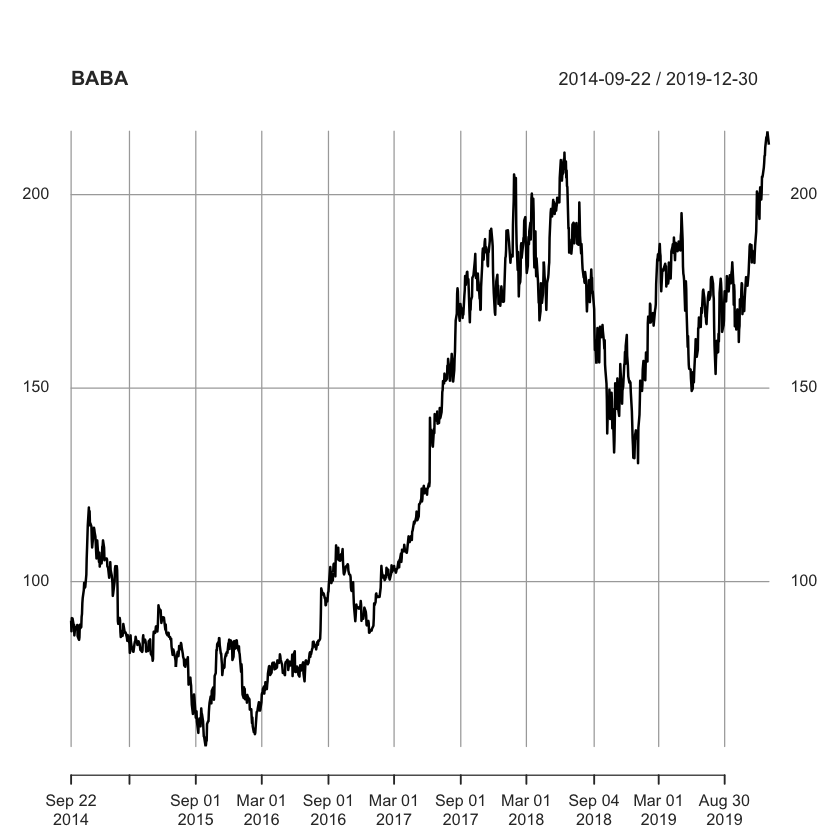

In [10]:
getSymbols('BABA', src = 'yahoo', return.class = 'xts',from = "2014-09-20",to="2019-12-31")
head(BABA)
BABA <- BABA[,"BABA.Close"]

plot.xts(BABA, ylab = NA)

clearly non-stationary, lets calculate log returns

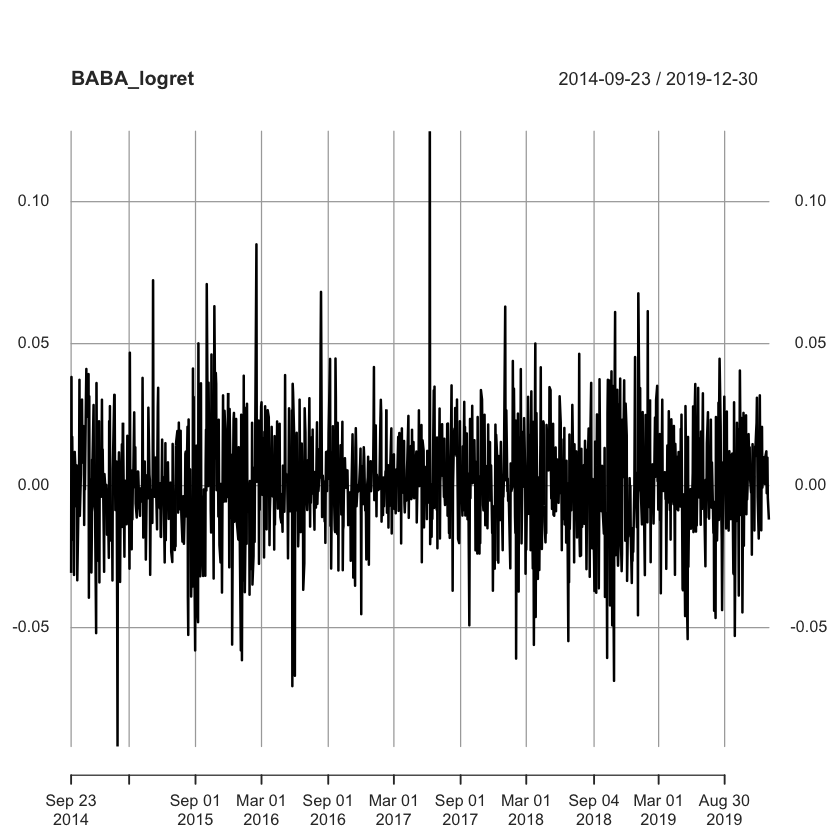

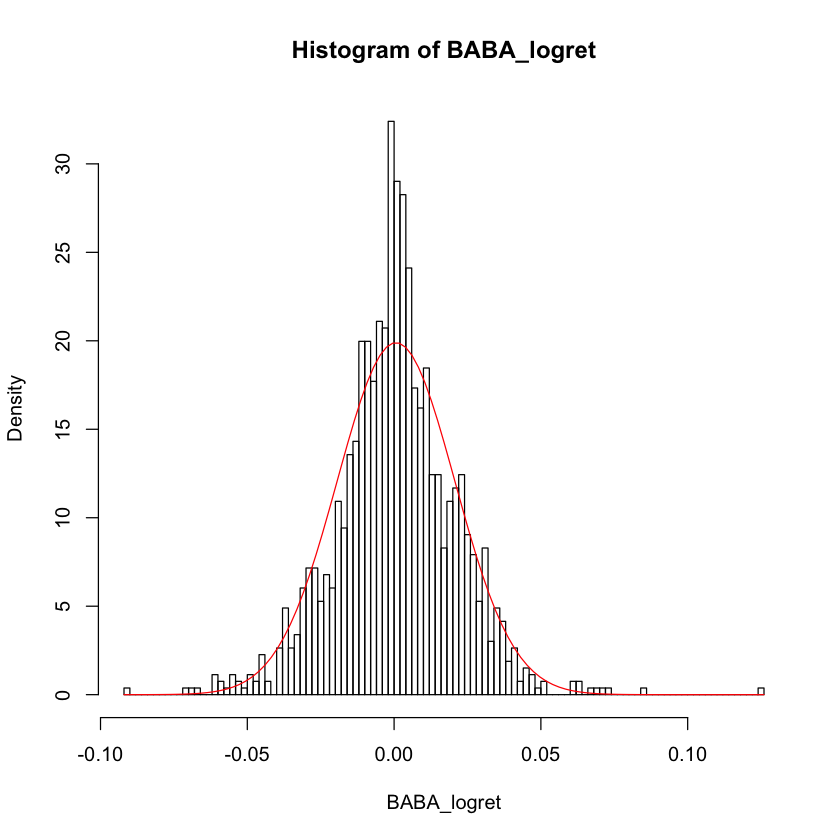

In [19]:
BABA_logret <- na.omit(diff(log(BABA)))

plot.xts(BABA_logret, ylab = NA)
hist(BABA_logret,freq=FALSE,breaks=100)
curve(dnorm(x, mean=mean(BABA_logret), sd=sd(BABA_logret)), add=TRUE, col="red")

In [21]:
adf <- data.frame("lags"=1:10,"p-val"=NA)

for (i in 1:10){
    adf[i,"p.val"] =as.numeric(adf.test(BABA_logret, k = i)$p.val)  
}
adf

ERROR: Error in adf.test(BABA_logret, k = i): unused argument (k = i)


stationary, lets examine ACF and PACF

In [ ]:
par(mfrow = c(2, 1))
acf(BABA_logret)
pacf(BABA_logret)

Also lets test joint significance of lags

In [ ]:
LB <- data.frame("lags"=1:10,"p-val"=NA)

for (i in 1:10){
    LB[i,"p.val"] =Box.test(BABA_logret, type = "Ljung-Box", lag = i)$p.val
}
LB

Null hypothesis of autocorrelations up to lag k equal zero is very likely to be rejected (according to Ljung box test)

From ACF and PACF as well as Box-Ljung test it appears that there is a dependence on lags in both subsamples and therefore I will proceed to GARCH.

BUT from ACF/ PACF it is unclear, what order of AR or MA should be used, we will therefore focus on AIC/BIC

In [ ]:
custom_ARIMA <- function(dat,max_p,max_q, d, const){
  model_config <-c()
  model_AIC <-c()
  model_BIC <-c()
  Ljung_Box_pval <-c()
  RMSE <- c()
  for (i in 1:(max_p+1)){
    for (j in 1:(max_q+1)){
          arima<- tryCatch(Arima(dat,  # variable
                                 order = c(i-1,d,j-1),  # (p,d,q) parameters
                                 include.constant = const),
                           warning = function(w) {print(paste("non-finite finite-difference value", ''));
                             NaN},
                           error = function(e) {print(paste("non-finite finite-difference value", ''));
                             NaN})
          
          if (!is.numeric(arima)){
            model_config <-c(model_config, 
                             paste(i-1,d,j-1,sep=',')
                             )
            model_AIC <- c(model_AIC, (AIC(arima)))
            model_BIC <- c(model_BIC, (BIC(arima)))
            Ljung_Box_pval <-c(Ljung_Box_pval,(as.numeric(sub(".*p-value = ","", 
                                                              capture.output(checkresiduals(arima, plot=FALSE)[5]))[5])))
            RMSE_tmp <-round(sqrt(mean((as.vector(arima$fitted) - as.vector(dat))^2)),1)
            RMSE <- c(RMSE, RMSE_tmp)
          }
        }
      }
  df <- as.data.frame(cbind(model_config, 
                            model_AIC,
                            as.numeric(as.character(model_BIC)),
                            as.numeric(as.character(Ljung_Box_pval)),
                            RMSE))
  names(df) <- c('model_config','model_AIC','model_BIC','Ljung_Box_pval','RMSE')
  df$model_config <- as.character(df$model_config)
  df$model_AIC <- as.numeric(as.character(df$model_AIC))
  df$model_BIC <- as.numeric(as.character(df$model_BIC))
  df$Ljung_Box_pval <- as.numeric(as.character(df$Ljung_Box_pval))
  return(df)
}

custom_ARIMA_results <- custom_ARIMA(BABA_logret, 10, 10, 0, FALSE)


In [ ]:
head(custom_ARIMA_results[order(custom_ARIMA_results$model_AIC),],5)

head(custom_ARIMA_results[order(custom_ARIMA_results$model_BIC),],5)

In [ ]:
auto.arima(BABA_logret,ic ="aic")

# proc to neodpovida nasi tabulce??

zatim jsem vybral jen tu 2-0-2, muzeme vzit jinou/ vice zaroven

In [ ]:
arima202 <- arima(BABA_logret, order = c(2, 0, 2))
arima202
arch.test(arima202)

homoskedastic residuals rejected => focus on conditional volatility (GARCH family models)

# Conditional volatility

We start with ARMA(2,0,2)-GARCH(1,1) and save last 183 observations (6 months) for out of sample forecasting

In [ ]:
arma202_garch11_spec = ugarchspec(mean.model = list(armaOrder=c(2, 2)), variance.model = list(model = "sGARCH", garchOrder = c(1, 1)))

arma202_garch11= ugarchfit(arma202_garch11_spec, BABA_logret, out.sample = 183)

arma202_garch11

From the results we can see that all coefficients except mean are significant and null hypothesis of no autocorellation cannot be rejected (Ljung Box test). 

Testing normality

In [ ]:
jarque.bera.test(residuals(arma202_garch11))

par(mfrow = c(1, 2))

hist(residuals(arma202_garch11), breaks = 30, main ='Histogram', cex.main = 0.8, cex.lab = 0.8, xlab = NA,
    cex.axis = 0.8)
box()

qqnorm(residuals(arma202_garch11), cex.main = 0.8, cex.lab = 0.8, cex.axis = 0.8) 
qqline(residuals(arma202_garch11), lwd = 2)

residuals do not appear to be normally distributed, lets fit residuals having students t-distribution

In [ ]:
jarque.bera.test(residuals(arma202_garch11_t))

par(mfrow = c(1, 2))

hist(residuals(arma202_garch11_t), breaks = 30, main ='Histogram', cex.main = 0.8, cex.lab = 0.8, xlab = NA,
    cex.axis = 0.8)
box()

qqnorm(residuals(arma202_garch11_t), cex.main = 0.8, cex.lab = 0.8, cex.axis = 0.8) 
qqline(residuals(arma202_garch11_t), lwd = 2)

# Vubec to nepomohlo? smazat?

Lets try to fit models from GARCH family that account for asymmetric responses, namely EGARCH and GJRGARCH.
Starting with ARMA(2,0,2)-EGARCH(1,1)

In [ ]:
arma202_egarch11_spec <- ugarchspec(mean.model = list(armaOrder=c(2, 2)), variance.model = list(model = "eGARCH", 
                      garchOrder = c(1, 1)))


arma202_egarch11 = ugarchfit(arma202_egarch11_spec, BABA_logret, out.sample = 183)
arma202_egarch11

and GJRGARCH

In [ ]:
arma202_gjrgarch11_spec <- ugarchspec(mean.model = list(armaOrder=c(2, 2)), variance.model = list(model = "gjrGARCH", 
                      garchOrder = c(1, 1)))

arma202_gjrgarch11 = ugarchfit(arma202_gjrgarch11_spec, BABA_logret, out.sample = 183)
arma202_gjrgarch11

# jeste zkusit jine? EWMA?

Lets compare coefficients from all models

In [ ]:
coefficients <- cbind(coef(arma202_garch11),
                        coef(arma202_egarch11),
                        coef(arma202_gjrgarch11))

colnames(coefficients) <- c("ARMA(2,0,2)-GARCH(1,1)","ARMA(2,0,2)-EGARCH(1,1)","ARMA(2,0,2)-GJRGARCH(1,1)")
coefficients

And lets check which model performs the best according to AIC

# mozna srovnat i jinak? jine kriteria, mozna RMSE? 

In [ ]:
performance <- cbind(c(infocriteria(arma202_garch11)["Akaike",],
                        infocriteria(arma202_egarch11)["Akaike",],
                        infocriteria(arma202_gjrgarch11)["Akaike",]))
rownames(performance) <- c("ARMA(2,0,2)-GARCH(1,1)","ARMA(2,0,2)-EGARCH(1,1)","ARMA(2,0,2)-GJRGARCH(1,1)")
performance


Now lets perform dynamic forecast and set the forecast horizon to 6 months

In [ ]:
forecast_arma202_garch11 = ugarchforecast(arma202_garch11, n.ahead = 1, n.roll = 183)
forecast_arma202_egarch11 = ugarchforecast(arma202_egarch11, n.ahead = 1, n.roll = 183)
forecast_arma202_gjrgarch11 = ugarchforecast(arma202_gjrgarch11, n.ahead = 1, n.roll = 183)

In [ ]:
par(mfrow = c(1, 1))
plot.ts(arma202_garch11@fit$sigma, ylab = NA, xlim = c(0, length(BABA_logret)), main = 'Volatility forecasts')
lines(c(rep(NA, length(BABA_logret) - 183 - 1), forecast_arma202_garch11@forecast$sigma), col = 'red')

lines(c(rep(NA, length(BABA_logret) - 183 - 1), forecast_arma202_egarch11@forecast$sigma), col = 'blue')

lines(c(rep(NA, length(BABA_logret) - 183 - 1), forecast_arma202_gjrgarch11@forecast$sigma), col = 'orange')

From the graphs we can see that they produce similar predictions, lets examine MSE.

First I bind the prediction vectors

In [ ]:
predictions  <- cbind(forecast_arma202_garch11@forecast$sigmaFor[1:183],
                      forecast_arma202_egarch11@forecast$sigmaFor[1:183],
                      forecast_arma202_gjrgarch11@forecast$sigmaFor[1:183])

Then I calculate volatility proxy

In [ ]:
vol <- (tail(BABA_logret,183))^2

And finally proceed to MSE

In [ ]:
MSE_results <- cbind(MSE(y_pred = predictions[1], y_true = vol),
                     MSE(y_pred = predictions[2], y_true = vol),
                     MSE(y_pred = predictions[3], y_true = vol))


colnames(MSE_results) <- c('ARMA(2,0,2)-GARCH(1,1)',
                          'ARMA(2,0,2)-eGARCH(1,1)',
                          'ARMA(2,0,2)-gjrGARCH(1,1)')

MSE_results

ARMA(2,0,2)-gjrGARCH(1,1) appears to perform best in terms of mean squared error